# Ninjacart: CV Classification

## Problem Statement

- Ninjacart is India's largest fresh produce supply chain company. They are pioneers in solving one of the toughest supply chain problems of the world by leveraging innovative technology. They source fresh produce from farmers and deliver them to businesses within 12 hours. An integral component of their automation process is the development of robust classifiers which can distinguish between images of different types of vegetables, while also correctly labeling images that do not contain any one type of vegetable as noise.

- As a starting point, ninjacart has provided us with a dataset scraped from the web which contains train and test folders, each having 4 sub-folders with images of onions, potatoes, tomatoes and some market scenes. We have been tasked with preparing a multiclass classifier for identifying these vegetables. The dataset provided has all the required images to achieve the task.

In [29]:
import torch.nn as nn
import torch
from torchvision import transforms
from torch.utils.data import DataLoader,random_split
from torch.utils.tensorboard import SummaryWriter
from torchvision.datasets import ImageFolder
from torchvision import models
import torchmetrics
from torchsummary import summary

import pathlib
import os
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import datetime
import random

from tqdm import tqdm_notebook as tqdm

In [2]:
sns.set_style("darkgrid")
device = "cuda" if torch.cuda.is_available() else "cpu"


In [6]:
train_path = pathlib.Path("/Scaler/NinjaCart_Project/ninjacart_data/train/")
test_path = pathlib.Path("/Scaler/NinjaCart_Project/ninjacart_data/test/")

train_count = {}
test_count = {}

print("*"*25,"Train Images", "*"*25)
print("\n")
count = 0
for i in os.listdir(train_path):
    for j in os.listdir(os.path.join(train_path,i)):
        if i not in train_count:
            train_count[i] = [j]
        train_count[i].append(j)
    count+=len(train_count[i])
    print(f"Total Images in {i} folder: {len(train_count[i])}")
print(f"Total train images: {count}")

print("*"*25,"Test Images", "*"*25)
print("\n")
count = 0
for i in os.listdir(test_path):
    for j in os.listdir(os.path.join(test_path,i)):
        if i not in test_count:
            test_count[i] = [j]
        test_count[i].append(j)
    count+=len(test_count[i])
    print(f"Total Images in {i} folder: {len(test_count[i])}")

print(f"Total test images: {count}")

************************* Train Images *************************


Total Images in indian market folder: 600
Total Images in onion folder: 850
Total Images in potato folder: 899
Total Images in tomato folder: 790
Total train images: 3139
************************* Test Images *************************


Total Images in indian market folder: 82
Total Images in onion folder: 84
Total Images in potato folder: 82
Total Images in tomato folder: 107
Total test images: 355


### Exploratory Data Analysis.

#### Plotting class distribution & Visualizing Image dimensions with their plots

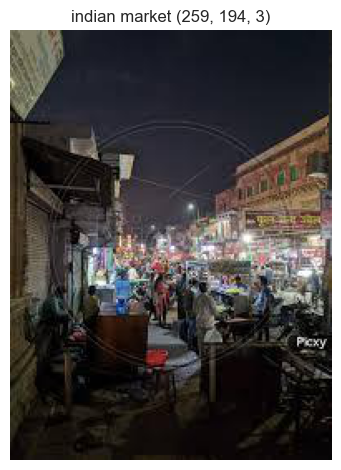

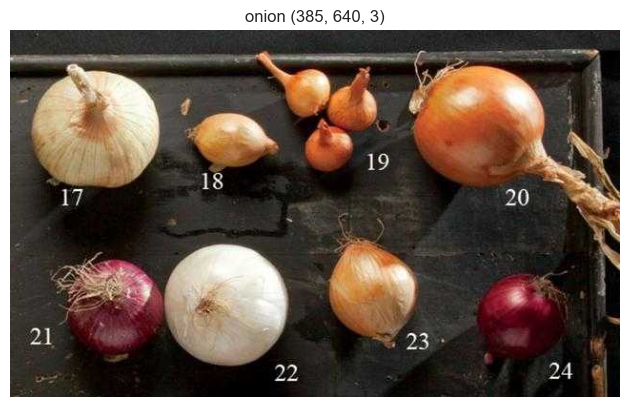

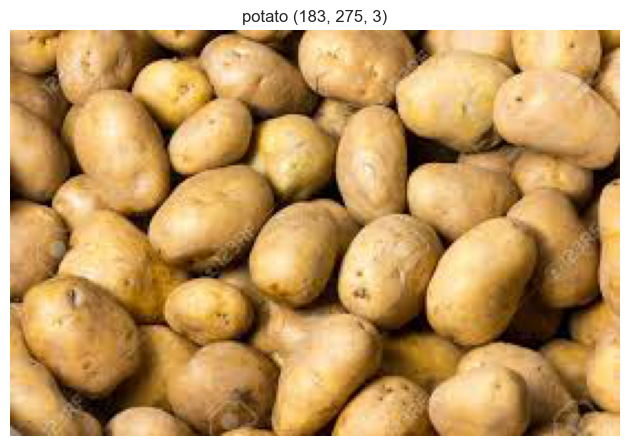

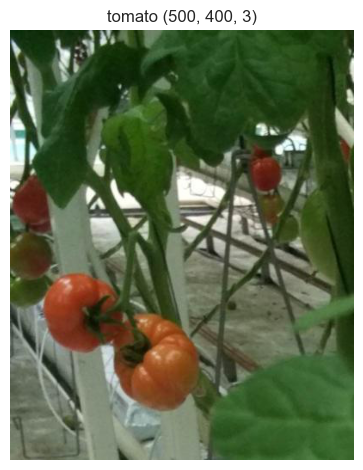

In [4]:
for i in os.listdir(train_path):
    for j in os.listdir(os.path.join(train_path,i)):
        img = plt.imread(os.path.join(train_path,i,j))
        plt.imshow(img)
        plt.title(f"{i} {img.shape}")
        plt.axis("off")
        plt.tight_layout()
        plt.show()
        break


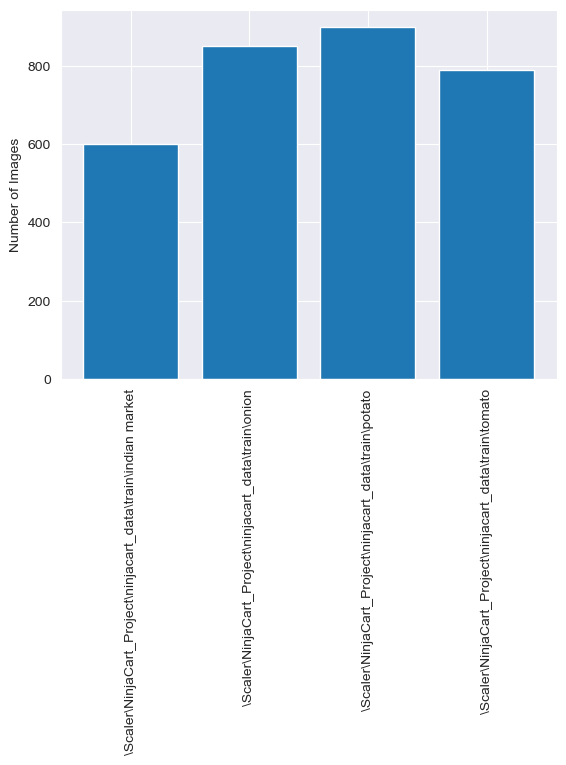

In [5]:
subdirectories = [os.path.join(train_path, d) for d in os.listdir(train_path) if os.path.isdir(os.path.join(train_path, d))]

# Count the number of images in each subdirectory
counts = [0] * len(subdirectories)
for i, directory in enumerate(subdirectories):
    counts[i] = len(os.listdir(directory))

# Create a bar chart to visualize the distribution
plt.bar(subdirectories, counts)
plt.xticks(rotation=90)
plt.ylabel("Number of Images")
plt.show()

#### Splitting the dataset into train, validation, and test set

In [6]:
transform = transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.GaussianBlur(3),
            transforms.RandomRotation(10),
            transforms.Resize(500),
            transforms.CenterCrop(500),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406],
                                [0.229, 0.224, 0.225])
        ])

In [7]:
Data_folder = ImageFolder(train_path,transform=transform)


train, valid = random_split(Data_folder,[int(0.8*len(Data_folder)),int(0.2*len(Data_folder))],generator=torch.Generator().manual_seed(42))

train_data = DataLoader(train,batch_size=64,shuffle=True)
valid_data = DataLoader(valid,batch_size=64,shuffle=False)



In [8]:
def plot_loss_accuracy(hist):
    fig, ax = plt.subplots(2,figsize=(8,8))
    fig.suptitle('Loss & Accuracy', fontsize=16)
    loss = []
    val_loss = []
    accu = []
    val_accu = []
    for i in hist:
        loss.append(i["loss"].item())
        val_loss.append(i["Val_Loss"].item())
        accu.append(i["train_accuracy"].item())
        val_accu.append(i["Val_Accu"].item())
    ax[0].plot(loss)
    ax[0].plot(val_loss)
    ax[0].set_xlabel("Epochs")
    ax[0].set_ylabel("Loss")
    ax[0].set_title("Loss Graph")


    ax[1].plot(accu)
    ax[1].plot(val_accu)
    ax[1].set_xlabel("Epochs")
    ax[1].set_ylabel("Accuracy")
    ax[1].set_title("Accuracy Graph")

    plt.show()

- Training_loop

In [9]:
def accuracy(pred,label):
    _, out = torch.max(pred,dim=1)
    return torch.tensor(torch.sum(out==label).item()/len(pred))

def validation_loss(model,validdata,loss):
    model.eval()
    with torch.no_grad():
        val_acc = []
        val_los = []
        for img,label in validdata:
            img = img.to(device)
            label = label.to(device)
            out = model(img)
            val_los.append(loss(out,label).item())
            val_acc.append(accuracy(out,label))
        return torch.tensor(val_los).mean(),torch.tensor(val_acc).mean()


def training_loop(model,train_data,valid_data,epochs,loss,optim):
    writer = SummaryWriter(log_dir=r"D:\Scaler\NinjaCart_Project\Logs")
    history = []
    for epoch in range(epochs+1):
        running_loss = []
        run_accuracy = []
        for img, label in train_data:
            img = img.to(device)
            label = label.to(device)
            out = model(img)
            train_loss=loss(out,label)
            train_loss.backward()
            optim.step()
            optim.zero_grad()
            running_loss.append(train_loss.item())
            run_accuracy.append(accuracy(out,label))
        val_loss, val_acc = validation_loss(model,valid_data,loss)
        history.append({"loss":torch.tensor(running_loss).mean(),
                        "train_accuracy":torch.tensor(run_accuracy).mean(),
                        "Val_Loss": val_loss,
                        "Val_Accu" : val_acc
                        })
        writer.add_scalar("Training loss x epoch", torch.tensor(running_loss).mean(), epoch)
        writer.add_scalar("Validation loss x epoch", val_loss, epoch)
        writer.add_scalar("Train Accuracy x Epoch",torch.tensor(run_accuracy).mean(),epoch)
        writer.add_scalar("Val Accuracy x Epoch",val_acc,epoch)
        print("{} Epoch {}, Training loss {},Train_accu {} Val_loss {}, Val_ Accuracy {}".format(datetime.datetime.now(), epoch, torch.tensor(running_loss).mean(),torch.tensor(run_accuracy).mean(),  val_loss, val_acc))
    return history

### Creating model architecture and training 

#### CNN Classifier model from scratch

In [22]:
class BaseCnn(nn.Module):
    def __init__(self,num_channel) -> None:
        super().__init__()
        self.conv_layer1 = nn.Sequential(
            nn.Conv2d(in_channels=num_channel,out_channels=num_channel*2,kernel_size=3,stride=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.BatchNorm2d(num_channel*2)
        ) 
        self.conv_layer2 = nn.Sequential(
            nn.Conv2d(in_channels=num_channel*2,out_channels=num_channel*4,kernel_size=3,stride=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.BatchNorm2d(num_channel*4)
        )
        self.conv_layer3 = nn.Sequential(
            nn.Conv2d(in_channels=num_channel*4,out_channels=num_channel*8,kernel_size=3,stride=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.BatchNorm2d(num_channel*8)
        )
        self.fc_layer1 = nn.Sequential(
            nn.Linear(24*60*60,512),
            nn.ReLU()
        )
        self.fc_layer2 = nn.Sequential(
            nn.Linear(512,4),
            nn.LogSoftmax(dim=1)
        )
    
    def forward(self,x):
        out = self.conv_layer1(x)
        out = self.conv_layer2(out)
        out = self.conv_layer3(out)

        # print(out.shape)
        out = out.view(-1,24*60*60)

        out = self.fc_layer1(out)
        out = self.fc_layer2(out)
        return out

In [50]:
model = BaseCnn(num_channel=3)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(),lr=0.001)

model.to(device)

BaseCnn(
  (conv_layer1): Sequential(
    (0): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer2): Sequential(
    (0): Conv2d(6, 12, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer3): Sequential(
    (0): Conv2d(12, 24, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc_layer1): Sequential(
    (0): Linear(in_features=86400, out_features=512, bias=True)
    (1): ReLU()
  )
  (fc_layer2): Sequential(
    (0): Linea

In [51]:
hist = training_loop(epochs=5,model=model,loss=criterion,optim=optimizer,train_data=train_data,valid_data=valid_data)

2023-10-11 22:27:27.338044 Epoch 0, Training loss 6.330111980438232,Train_accu 0.6819010376930237 Val_loss 3.962353229522705, Val_ Accuracy 0.6522058844566345


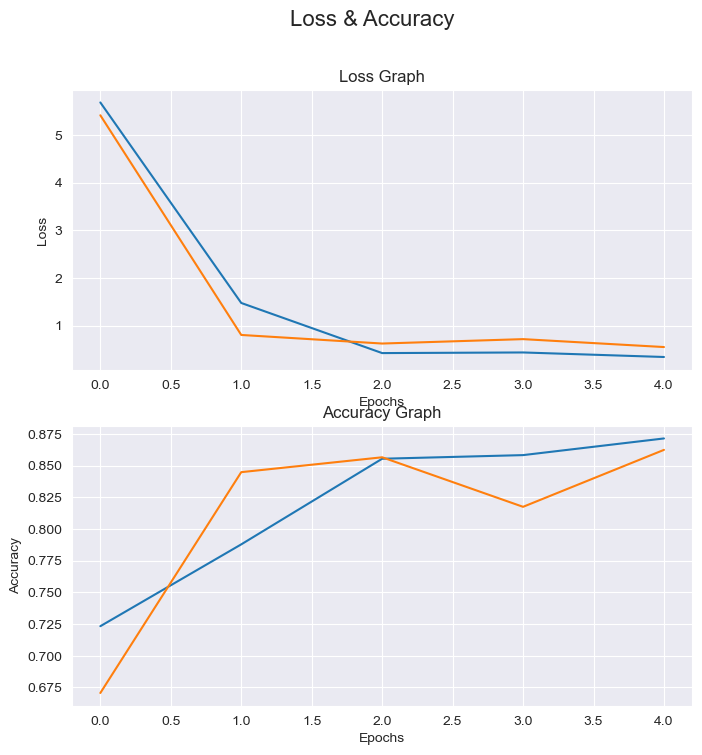

In [57]:
plot_loss_accuracy(hist[:-1])

In [64]:
weights_path = r"D:\Scaler\NinjaCart_Project\Weights\Basemodel.pth"
torch.save(model.state_dict(), weights_path)

#### ComplexCnn for smooth fitting

In [23]:
class ComplexCnn(nn.Module):
    def __init__(self,num_channel) -> None:
        super().__init__()
        self.conv_layer1 = nn.Sequential(
            nn.Conv2d(in_channels=num_channel,out_channels=num_channel*2,kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(num_channel*2),

            nn.Conv2d(in_channels=num_channel*2,out_channels=num_channel*4,stride=2,kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(num_channel*4),
        
            nn.Conv2d(in_channels=num_channel*4,out_channels=32,kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2,2),
        
            nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2,2),

            nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2,2)
        )
        
        self.fc_layer1 = nn.Sequential(
            nn.Linear(128*29*29,512),
            nn.ReLU(),

            nn.Linear(512,256),
            nn.ReLU(),

            nn.Linear(256,4),
            nn.LogSoftmax(dim=1)
        )
    
    def forward(self,x):
        out = self.conv_layer1(x)

        # print(out.shape)
        out = out.view(-1,128*29*29)

        out = self.fc_layer1(out)
        
        return out

In [14]:
model = ComplexCnn(num_channel=3)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(),lr=0.001)

model.to(device)

ComplexCnn(
  (conv_layer1): Sequential(
    (0): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(6, 12, kernel_size=(3, 3), stride=(2, 2))
    (4): ReLU()
    (5): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(12, 32, kernel_size=(3, 3), stride=(1, 1))
    (7): ReLU()
    (8): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (11): ReLU()
    (12): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (15): ReLU()
    (16): BatchNorm2d(128, eps=1e-05, momentum=0.1, affin

In [15]:
hist = training_loop(epochs=10,model=model,loss=criterion,optim=optimizer,train_data=train_data,valid_data=valid_data)

2023-10-11 15:14:26.086776 Epoch 0, Training loss 1.735496163368225,Train_accu 0.6869791746139526 Val_loss 1.1578682661056519, Val_ Accuracy 0.6717524528503418
2023-10-11 15:16:02.502520 Epoch 1, Training loss 0.7086995840072632,Train_accu 0.7718750238418579 Val_loss 0.5053683519363403, Val_ Accuracy 0.8276654481887817
2023-10-11 15:17:43.472027 Epoch 2, Training loss 0.4083729684352875,Train_accu 0.8473957777023315 Val_loss 0.46034055948257446, Val_ Accuracy 0.8429228067398071
2023-10-11 15:19:25.025675 Epoch 3, Training loss 0.3666824996471405,Train_accu 0.868359386920929 Val_loss 0.4212194085121155, Val_ Accuracy 0.8573835492134094
2023-10-11 15:21:07.972460 Epoch 4, Training loss 0.36614498496055603,Train_accu 0.8674479722976685 Val_loss 0.446850448846817, Val_ Accuracy 0.8616727590560913
2023-10-11 15:22:49.660638 Epoch 5, Training loss 0.3059066832065582,Train_accu 0.8868489265441895 Val_loss 0.4073648452758789, Val_ Accuracy 0.8730085492134094
2023-10-11 15:24:30.503931 Epoch 6,

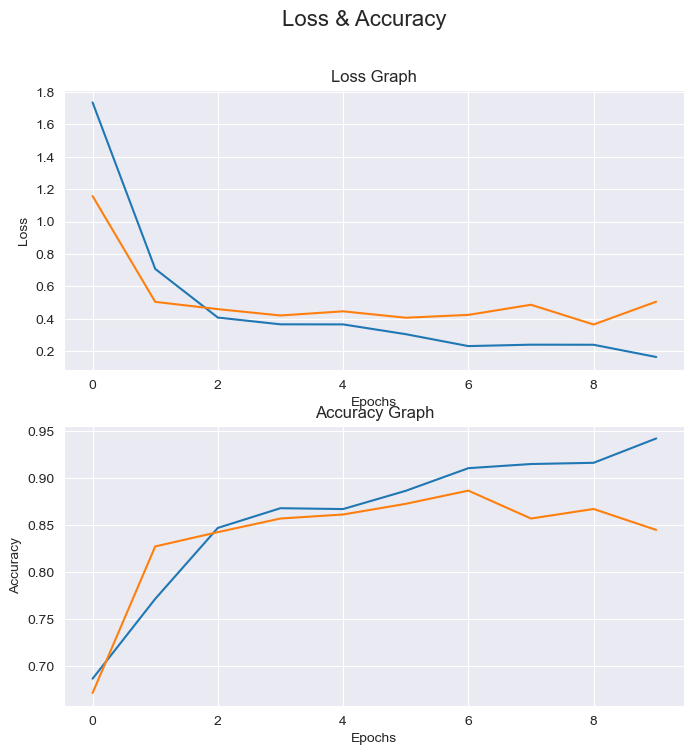

In [16]:
plot_loss_accuracy(hist[:-1])

In [18]:
weights_path = r"D:\Scaler\NinjaCart_Project\Weights\Complexmodel.pth"
torch.save(model.state_dict(), weights_path)

#### ComplexCnn1 with l2 Regularization and Dropout parameters

In [10]:
class ComplexCnn1(nn.Module):
    def __init__(self,num_channel) -> None:
        super().__init__()
        self.conv_layer1 = nn.Sequential(
            nn.Conv2d(in_channels=num_channel,out_channels=num_channel*2,kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(num_channel*2),

            nn.Conv2d(in_channels=num_channel*2,out_channels=num_channel*4,stride=2,kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(num_channel*4),
        
            nn.Conv2d(in_channels=num_channel*4,out_channels=32,kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2,2),
        
            nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2,2),

            nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2,2)
        )
        
        self.fc_layer1 = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(128*29*29,512),
            nn.ReLU(),
            
            nn.Dropout(0.3),
            nn.Linear(512,256),
            nn.ReLU(),
            
            nn.Dropout(0.3),
            nn.Linear(256,4),
            nn.LogSoftmax(dim=1)
        )
    
    def forward(self,x):
        out = self.conv_layer1(x)

        # print(out.shape)
        out = out.view(-1,128*29*29)

        out = self.fc_layer1(out)
        
        return out

In [11]:
model = ComplexCnn1(num_channel=3)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(),lr=0.001,weight_decay=1e-5)

model.to(device)


ComplexCnn1(
  (conv_layer1): Sequential(
    (0): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(6, 12, kernel_size=(3, 3), stride=(2, 2))
    (4): ReLU()
    (5): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(12, 32, kernel_size=(3, 3), stride=(1, 1))
    (7): ReLU()
    (8): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (11): ReLU()
    (12): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (15): ReLU()
    (16): BatchNorm2d(128, eps=1e-05, momentum=0.1, affi

In [12]:
hist = training_loop(model=model,train_data=train_data,valid_data=valid_data,epochs=10,loss=criterion,optim=optimizer)

2023-10-11 22:46:11.445330 Epoch 0, Training loss 2.755383253097534,Train_accu 0.6334635019302368 Val_loss 1.2032948732376099, Val_ Accuracy 0.6600490212440491
2023-10-11 22:47:53.123661 Epoch 1, Training loss 0.6931974291801453,Train_accu 0.7730468511581421 Val_loss 0.6757590174674988, Val_ Accuracy 0.7596813440322876
2023-10-11 22:49:34.036219 Epoch 2, Training loss 0.5559856295585632,Train_accu 0.8026041984558105 Val_loss 0.45714253187179565, Val_ Accuracy 0.8218137621879578
2023-10-11 22:51:09.774744 Epoch 3, Training loss 0.37543243169784546,Train_accu 0.8550781011581421 Val_loss 0.43442726135253906, Val_ Accuracy 0.8511335253715515
2023-10-11 22:52:43.598312 Epoch 4, Training loss 0.34399253129959106,Train_accu 0.8783854246139526 Val_loss 0.49789175391197205, Val_ Accuracy 0.819087028503418
2023-10-11 22:54:17.381893 Epoch 5, Training loss 0.2894912660121918,Train_accu 0.8872395753860474 Val_loss 0.39725929498672485, Val_ Accuracy 0.8702818751335144
2023-10-11 22:55:51.297775 Epo

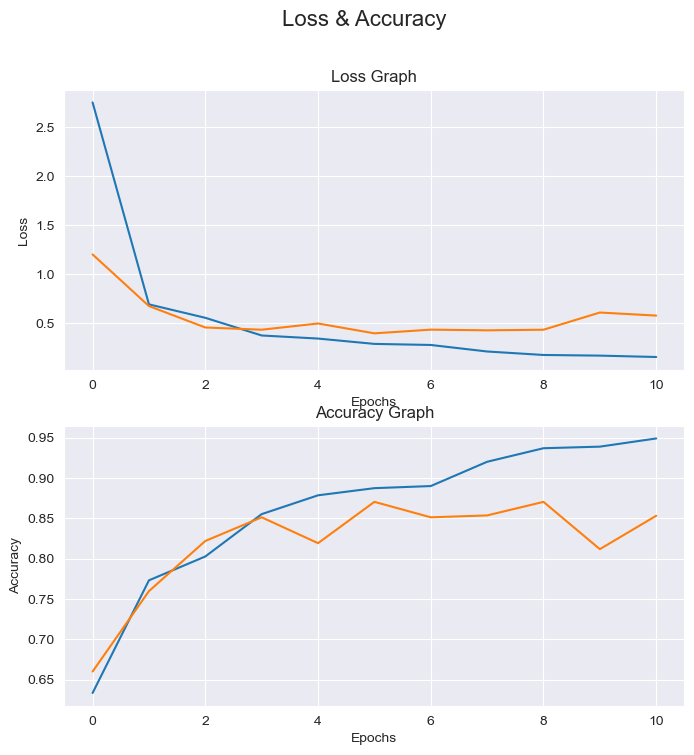

In [13]:
plot_loss_accuracy(hist)

In [14]:
weights_path = r"D:\Scaler\NinjaCart_Project\Weights\Complexmodel_with_overfitting.pth"
torch.save(model.state_dict(), weights_path)

#### Pretrained Model -- ResNet50

In [11]:
model = models.resnet50(pretrained=True)
# since we are using the ResNet50 model as a feature extractor we set
# its parameters to non-trainable (by default they are trainable)
for param in model.parameters():
	param.requires_grad = False
# on to the current device
modelOutputFeats = model.fc.in_features
model.fc = nn.Linear(modelOutputFeats, 4)
model = model.to(device)

c:\Users\revan\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\revan\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to C:\Users\revan/.cache\torch\hub\checkpoints\resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(),lr=0.001)

In [13]:
hist = training_loop(model=model,train_data=train_data,valid_data=valid_data,epochs=20,loss=criterion,optim=optimizer)

2023-10-11 17:34:43.100686 Epoch 0, Training loss 0.7595013380050659,Train_accu 0.751953125 Val_loss 0.3463861346244812, Val_ Accuracy 0.9441176652908325
2023-10-11 17:36:44.512801 Epoch 1, Training loss 0.29463303089141846,Train_accu 0.9305989146232605 Val_loss 0.20936469733715057, Val_ Accuracy 0.9574142694473267
2023-10-11 17:38:45.014544 Epoch 2, Training loss 0.20497548580169678,Train_accu 0.9507812261581421 Val_loss 0.1662873923778534, Val_ Accuracy 0.9609375
2023-10-11 17:40:43.290859 Epoch 3, Training loss 0.16220775246620178,Train_accu 0.959765613079071 Val_loss 0.13619402050971985, Val_ Accuracy 0.9624999761581421
2023-10-11 17:42:42.597787 Epoch 4, Training loss 0.1435335874557495,Train_accu 0.964062511920929 Val_loss 0.12438507378101349, Val_ Accuracy 0.9714767336845398
2023-10-11 17:44:42.348485 Epoch 5, Training loss 0.13055306673049927,Train_accu 0.96875 Val_loss 0.11077388375997543, Val_ Accuracy 0.96875
2023-10-11 17:46:43.640830 Epoch 6, Training loss 0.12291196733713

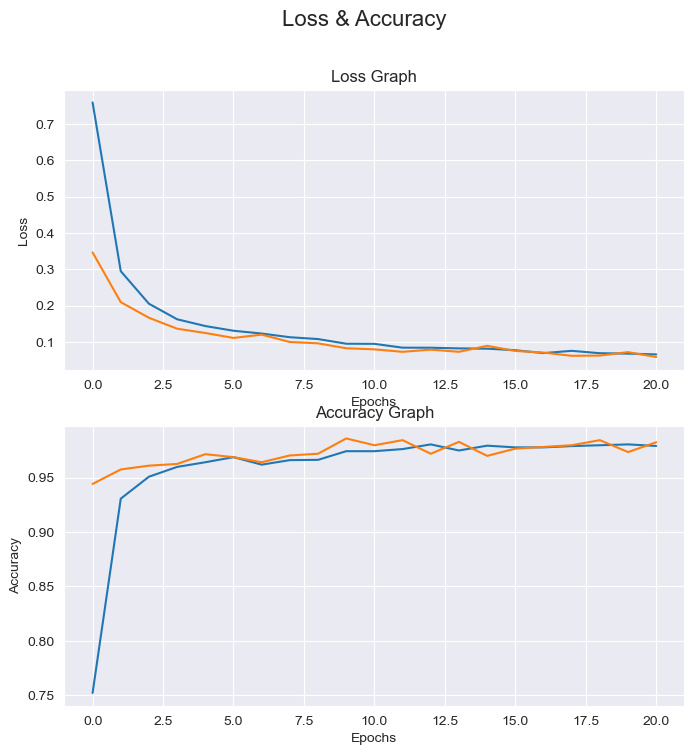

In [14]:
plot_loss_accuracy(hist)

In [16]:
weights_path = r"D:\Scaler\NinjaCart_Project\Weights\ResNetmodel.pth"
torch.save(model.state_dict(), weights_path)

#### MobileNet

In [33]:
model = models.mobilenet_v3_small(pretrained=True)
# since we are using the ResNet50 model as a feature extractor we set
# its parameters to non-trainable (by default they are trainable)
# on to the current device
model.classifier[3].out_features = 4

model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(),lr=0.001)

In [34]:
hist = training_loop(model=model,train_data=train_data,valid_data=valid_data,epochs=10,loss=criterion,optim=optimizer)

2023-10-11 20:56:25.749385 Epoch 0, Training loss 0.6206335425376892,Train_accu 0.8744791746139526 Val_loss 0.32880836725234985, Val_ Accuracy 0.8999693989753723
2023-10-11 20:58:18.099385 Epoch 1, Training loss 0.34168487787246704,Train_accu 0.8822916746139526 Val_loss 0.19669687747955322, Val_ Accuracy 0.9300551414489746
2023-10-11 20:59:48.573694 Epoch 2, Training loss 0.10252787917852402,Train_accu 0.9651042222976685 Val_loss 0.3195001184940338, Val_ Accuracy 0.9089460372924805
2023-10-11 21:01:15.518696 Epoch 3, Training loss 0.08810731023550034,Train_accu 0.971875011920929 Val_loss 0.10009181499481201, Val_ Accuracy 0.9699142575263977
2023-10-11 21:02:43.268059 Epoch 4, Training loss 0.06854832172393799,Train_accu 0.975390613079071 Val_loss 0.0793922170996666, Val_ Accuracy 0.973437488079071
2023-10-11 21:04:32.371338 Epoch 5, Training loss 0.06607703864574432,Train_accu 0.9761718511581421 Val_loss 0.08783284574747086, Val_ Accuracy 0.971875011920929
2023-10-11 21:06:15.774881 Ep

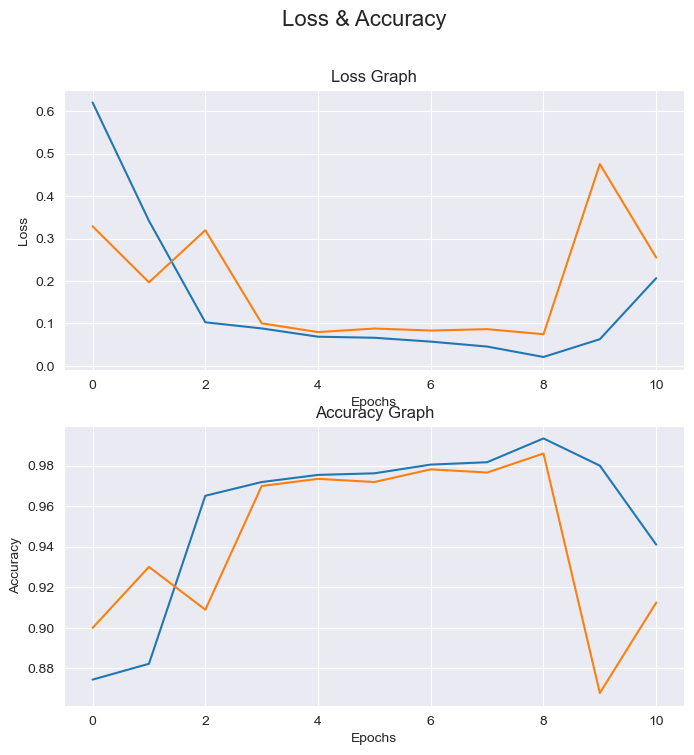

In [36]:
plot_loss_accuracy(hist)

In [37]:
summary(model, (3, 500, 500))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 250, 250]             432
       BatchNorm2d-2         [-1, 16, 250, 250]              32
         Hardswish-3         [-1, 16, 250, 250]               0
            Conv2d-4         [-1, 16, 125, 125]             144
       BatchNorm2d-5         [-1, 16, 125, 125]              32
              ReLU-6         [-1, 16, 125, 125]               0
 AdaptiveAvgPool2d-7             [-1, 16, 1, 1]               0
            Conv2d-8              [-1, 8, 1, 1]             136
              ReLU-9              [-1, 8, 1, 1]               0
           Conv2d-10             [-1, 16, 1, 1]             144
      Hardsigmoid-11             [-1, 16, 1, 1]               0
SqueezeExcitation-12         [-1, 16, 125, 125]               0
           Conv2d-13         [-1, 16, 125, 125]             256
      BatchNorm2d-14         [-1, 16, 1

In [38]:
weights_path = r"D:\Scaler\NinjaCart_Project\Weights\Mobilenet.pth"
torch.save(model.state_dict(), weights_path)

### Testing the best model

#### Test_Data

In [7]:
transform = transforms.Compose([
        transforms.Resize(500),
        transforms.CenterCrop(500),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


Test_folder = ImageFolder(test_path,transform=transform)
test_data = DataLoader(Test_folder,batch_size=64,shuffle=False,num_workers=4)


In [8]:
acc = torchmetrics.Accuracy(task="multiclass",num_classes=4)

#### Loading all trained model

In [12]:
def Testing(model,data,model_name):
    predictions = []
    ground_truth = []
    accuracy = []
    with torch.no_grad():
        for img, label in data:
            out = model(img)
            pred = [i.numpy().argmax() for i in out]
            accuracy.append(acc(out.argmax(dim=1),label))
            predictions = np.concatenate((predictions,pred))
            ground_truth = np.concatenate((ground_truth,label))
    confmat = torchmetrics.ConfusionMatrix(task="multiclass", num_classes=4)
    cm = confmat(torch.tensor(predictions),torch.tensor(ground_truth))
    plt.title(f"Confusion Matrix for {model_name}")
    plt.suptitle(f"Accuracy :{torch.tensor(accuracy).mean()*100}")
    sns.heatmap(cm,annot=True,fmt='d')
    plt.xlabel("Predictions")
    plt.ylabel("Ground Truth")
    plt.show()

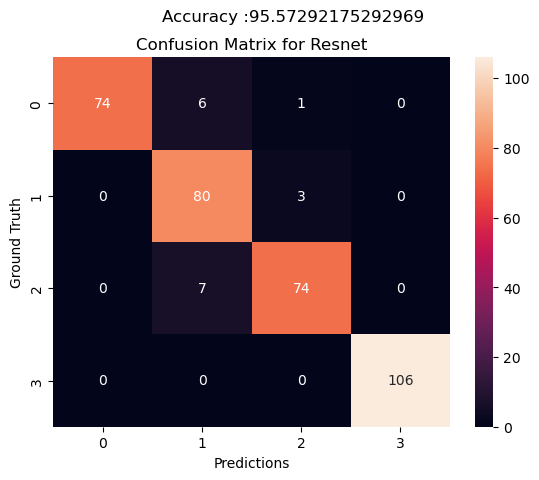

In [13]:
Resnet_model = models.resnet50()
modelOutputFeats = Resnet_model.fc.in_features
Resnet_model.fc = nn.Linear(modelOutputFeats, 4)
Resnet_model.load_state_dict(torch.load(r"D:\Scaler\NinjaCart_Project\Weights\ResNetmodel.pth"))
Resnet_model.eval()


Testing(model=Resnet_model,data=test_data,model_name="Resnet")

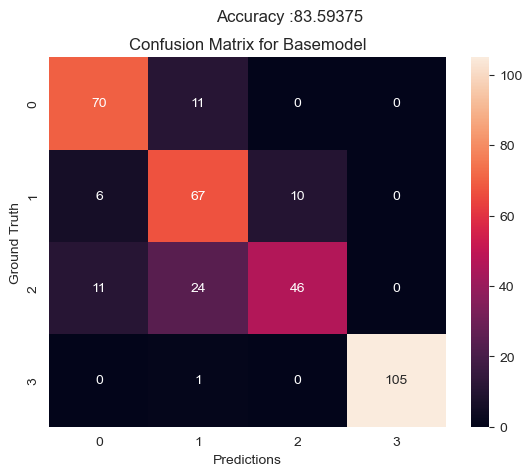

In [24]:
Base_model = BaseCnn(num_channel=3)
Base_model.load_state_dict(torch.load(r"D:\Scaler\NinjaCart_Project\Weights\Basemodel.pth"))
Base_model.eval()

Testing(model=Base_model,data=test_data,model_name="Basemodel")

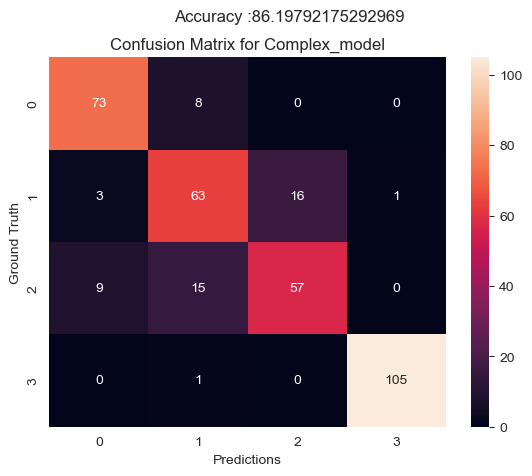

In [25]:
Complex_model = ComplexCnn(num_channel=3)
Complex_model.load_state_dict(torch.load(r"D:\Scaler\NinjaCart_Project\Weights\Complexmodel.pth"))
Complex_model.eval()

Testing(model=Complex_model,data=test_data,model_name="Complex_model")

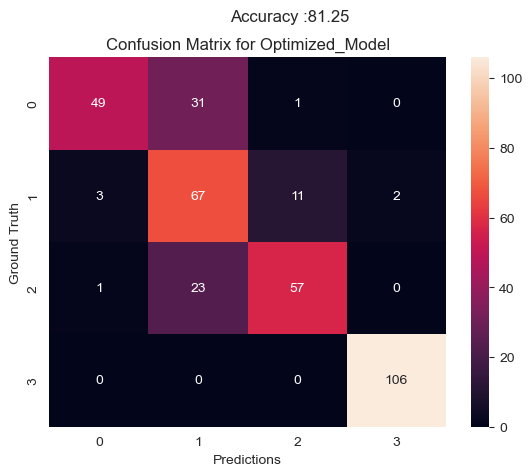

In [26]:
Optimized_Model = ComplexCnn1(num_channel=3)
Optimized_Model.load_state_dict(torch.load(r"D:\Scaler\NinjaCart_Project\Weights\Complexmodel_with_overfitting.pth"))
Optimized_Model.eval()

Testing(model=Optimized_Model,data=test_data,model_name="Optimized_Model")

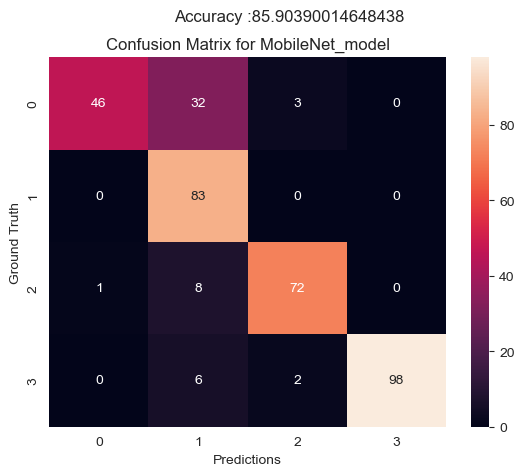

In [28]:
MobileNet_model = models.mobilenet_v3_small()
MobileNet_model.classifier[3].out_features = 4
MobileNet_model.load_state_dict(torch.load(r"D:\Scaler\NinjaCart_Project\Weights\Mobilenet.pth"))
MobileNet_model.eval()

Testing(model=MobileNet_model,data=test_data,model_name="MobileNet_model")

####  Random image samples prediction

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


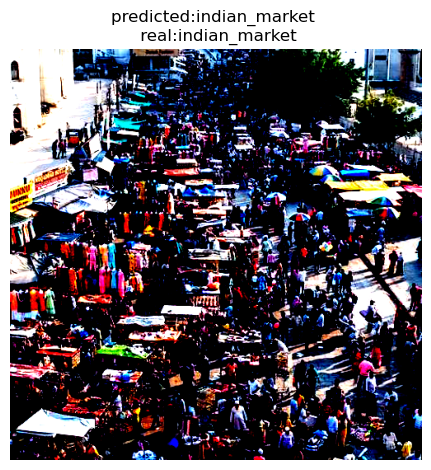

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


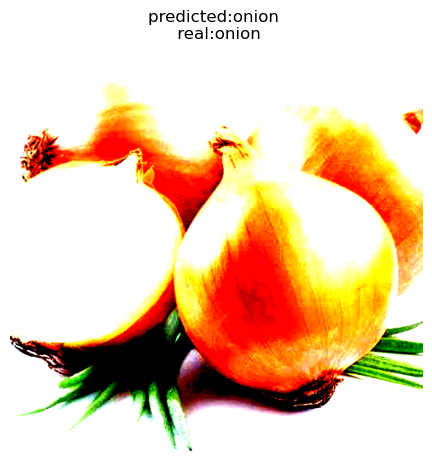

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


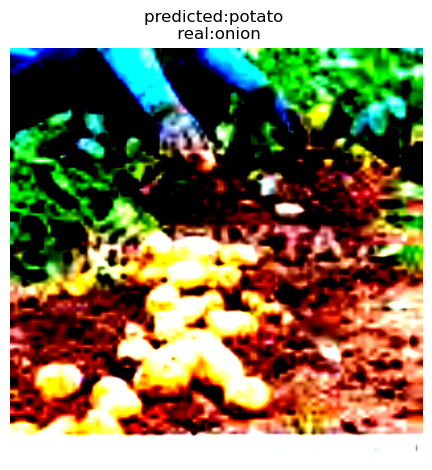

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


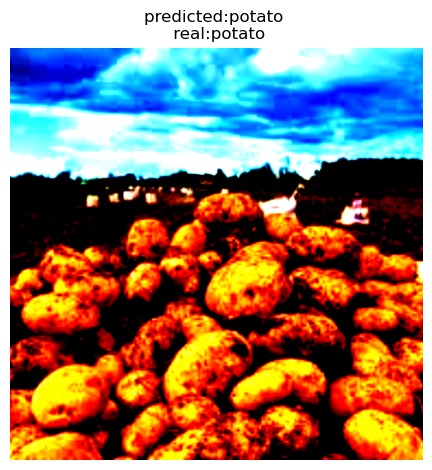

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


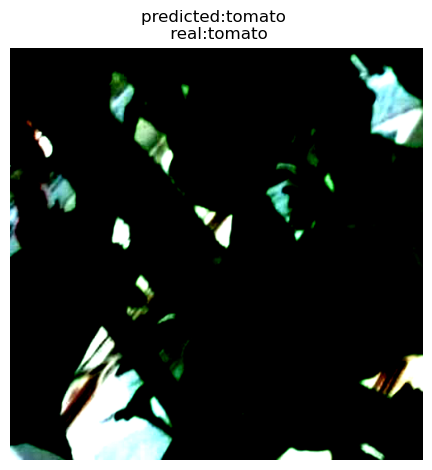

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


IndexError: index 37 is out of bounds for dimension 0 with size 31

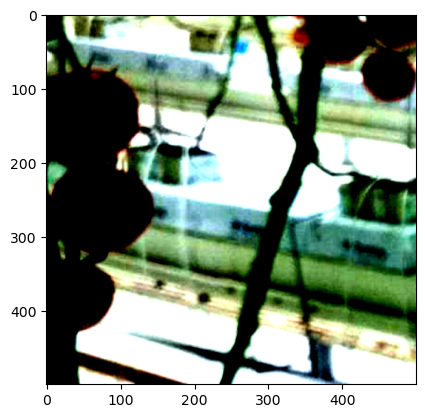

In [30]:
classes = ["indian_market","onion","potato","tomato"]
count = 0
with torch.no_grad():
    for i,(img, label) in enumerate(test_data):
        if i == count:
            image = img[random.randint(0,64)]
            out = Resnet_model(image.unsqueeze(0))
            pred = out.argmax()
            plt.imshow(image.numpy().transpose(1,2,0))
            plt.title(f"predicted:{classes[pred]} \n real:{classes[label[random.randint(0,64)]]}")
            plt.axis("off")
            plt.tight_layout()
            plt.show()
            count+=1
        else:
            break


### Summary & Insights

- We have tried different types of models from scratch
- But when compared to basic models, the pretrained models are doing very well in the performance because of its core architecture
- our model can also tried to optimize the performance well but not thatv much